# Regression Analysis for House Prices
**MBD 2018 - O2**  
**Dagoberto Romer**  
**ML2 Assignment**  
  
**NOTE:**  
For this assignment many things were tried, some of them did not improve the score so they were discarded. For the purpose of documentation, we leave the code present in the notebook but commented out so that we can check what has been done 

**Sources:**  
For this project I checked several Kernels in Kaggle to get different ideas of what I was able to do. These are:  

 - https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
 - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
 - https://www.kaggle.com/zavodrobotov/lasso-model-for-regression-problem
 - https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force  
Also the following book:  
 - http://shop.oreilly.com/product/0636920049081.do
 
 

## Import Libraries

In [1]:
import numpy as np  # For number related functions
import pandas as pd  # For data manipulation
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For plotting
%matplotlib inline

In [2]:
import warnings  # To remove future and deprecation warnings
warnings.filterwarnings('ignore')

In [3]:
from scipy import stats  # For stats functions
from scipy.stats import norm, skew, shapiro

In [4]:
# This is to set the pallete for graphs
color = sns.color_palette()
sns.set_style('white')
sns.set_palette('plasma')

## Import Data

In [5]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")

In [6]:
test_ids = test['Id']

In [7]:
print("Lenght of Train set: {}".format(len(train)))
print("Lenght of Test set: {}".format(len(test)))

Lenght of Train set: 1460
Lenght of Test set: 1459


In [8]:
print("Test Set IDs: ")
print("Lowest ID: {}".format(test['Id'].min()))
print("Highest ID: {}".format(test['Id'].max()))
print("Rows in Test Set: {}".format(len(test)))

Test Set IDs: 
Lowest ID: 1461
Highest ID: 2919
Rows in Test Set: 1459


In [9]:
print("Columns in Train Set: {}".format(len(train.columns)))
print("Columns in Test Set: {}".format(len(test.columns)))

Columns in Train Set: 81
Columns in Test Set: 80


We need to merge the sets together, First we check if there are sales at 0 in the train set to see if that's a valid number to set to the test set as a placeholder

In [10]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Minimum Price is 34900 so we can safely assign 0 to the test set Sales price and able to reseparate them later on.  

We also want to check the distribution of the target variable. As we're limited to linear models, they will perform better if the target variable is normally distributed

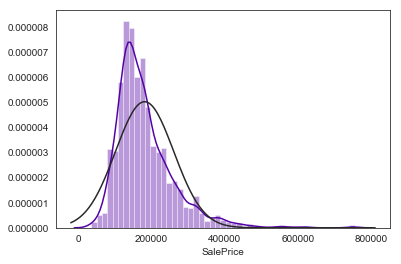

In [11]:
sns.distplot(train['SalePrice'], fit=norm)

Doesn't look like it is normally distributed but we run a formal test in case

In [12]:
shapiro(train['SalePrice'])[1]

3.206247534576162e-33

Shapiro's p-Value is less than 0.05 so we're confident that it's not normally distributed

We can use `np.log1p` to transform the Price and then `np.expm1` to revert the change 

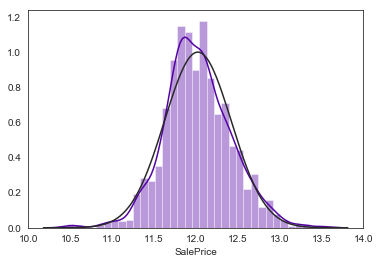

In [13]:
sns.distplot(train['SalePrice'].apply(np.log1p), fit=norm)

Not quite perfectly Normal distributed, but looking much better. We will use this just prior to training the model as we want the original Sale Price for EDA

In [14]:
test['SalePrice'] = 0

In [15]:
train.index = train['Id']
test.index = test['Id']

In [16]:
df = train.append(test)
df.drop('Id', axis=1, inplace=True)

## Data Quality

### Null Values

In [17]:
len(df.columns)  # Total Columns in Dataset

80

In [18]:
(df.isnull().sum() > 0).sum()  # Columns that have Null Values

34

Lots of columns need to be cleaned

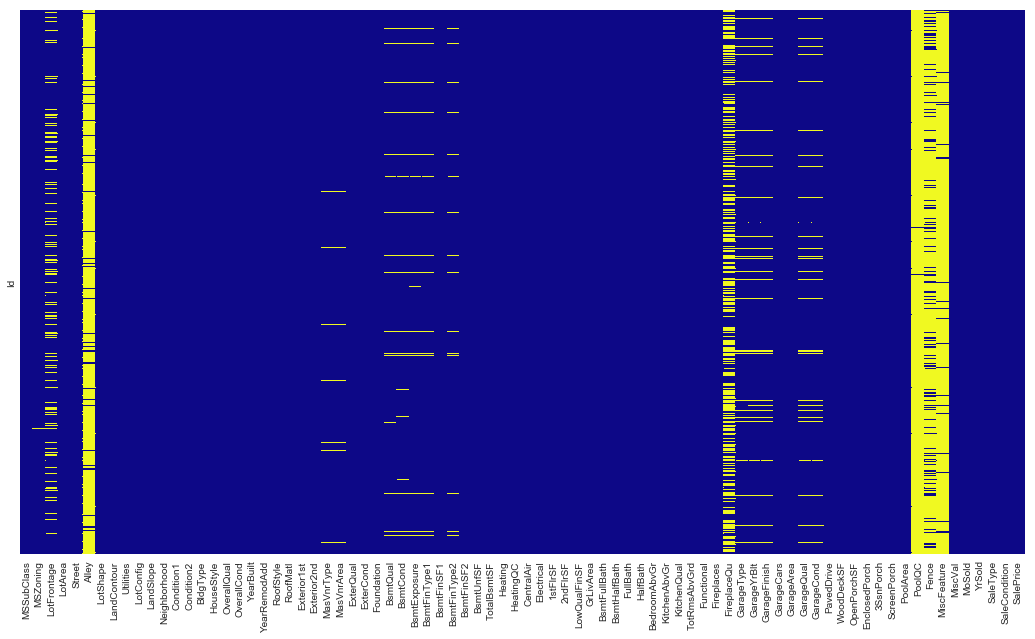

In [19]:
plt.subplots(figsize=(18,10))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')

We can see there are a lot of missing values here. 3 columns are mostly missing values like PoolIQC, Alley and  Fence and MscFeature

However we must be very careful because we can't remove any rows from the test set, so we will have to impute the missing values. Outliers need to be clipped or removes ONLY if they are in the training set

As there are too many columns, we will work with Null Values in batches of 15 columns at the time

In [20]:
null_cols = (df.isnull().sum()/len(df))
null_val = pd.DataFrame({'Null Ratio': null_cols})
null_val.drop(null_val[null_val['Null Ratio'] == 0].index, inplace=True)
sorted_null_val = null_val.sort_values('Null Ratio', ascending=False).head(15)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

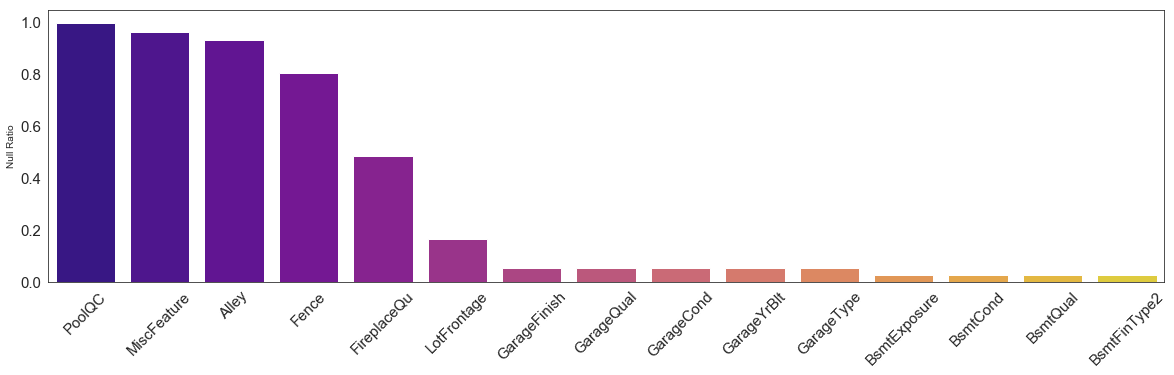

In [21]:
plt.subplots(figsize=(20,5))
sns.barplot(data=sorted_null_val, x=sorted_null_val.index, y='Null Ratio', palette='plasma')
plt.xticks(rotation=45, size=15)
plt.yticks(size=15)

As we saw, there are a lot of null values in our dataset. We will go from top to bottom in Null ratio and either impute or delete the variable (we can't delete rows for fear of deleting a row in the test set (which we can't do)

 - PoolQC seems to be the Quality of the Pool, according to the data description NA means there is no Pool

In [22]:
df['PoolQC'].fillna("None", inplace=True)

 - MiscFeature seems to be stuff like Elevators and Tennis Courts. NA means no misc feature

In [23]:
df['MiscFeature'].fillna("None", inplace=True)

 - Alley seems to be wether it's Paved or Gravel Alley access. NA means no Alley Access

In [24]:
df['Alley'].fillna("None", inplace=True)

 - Fence relates to the privacy of the house. NA means no fence available

In [25]:
df['Fence'].fillna("None", inplace=True)

 - FireplaceQu means Fireplace Quality. NA means there is no Fireplace

In [26]:
df['FireplaceQu'].fillna("None", inplace=True)

 - Lot Frontage is the linear feet of streets that connect a house. We can assume that the houses in the same neighborhood have roughly the same distribution and frontage. So we impute the median per neighborhood

In [27]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

**We check again the Null Values to see our progress**

In [28]:
null_cols = (df.isnull().sum()/len(df))
null_val = pd.DataFrame({'Null Ratio': null_cols})
null_val.drop(null_val[null_val['Null Ratio'] == 0].index, inplace=True)
sorted_null_val = null_val.sort_values('Null Ratio', ascending=False).head(15)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 <a list of 7 Text yticklabel objects>)

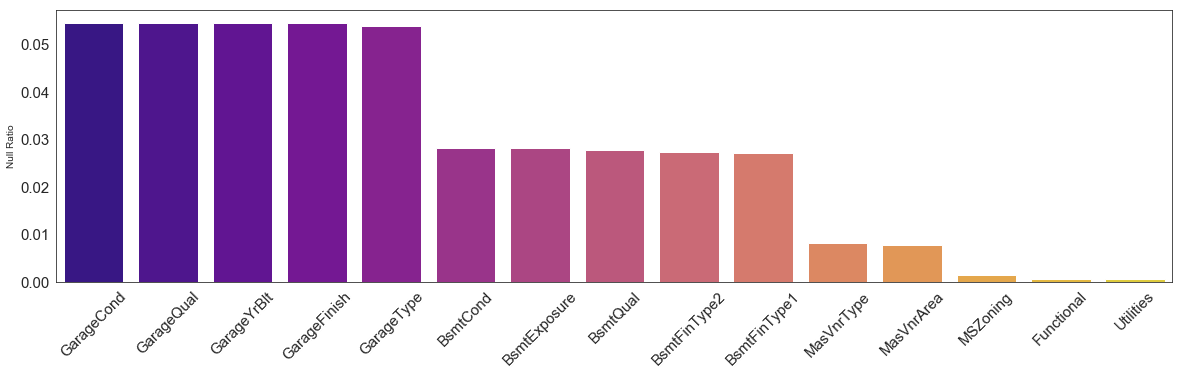

In [29]:
plt.subplots(figsize=(20,5))
sns.barplot(data=sorted_null_val, x=sorted_null_val.index, y='Null Ratio', palette='plasma')
plt.xticks(rotation=45, size=15)
plt.yticks(size=15)

The remaining features are all under 10% Null Ratio, we're making good progress

 - GarangeCond is just the condition of the garage. NA means that there is no garage

In [30]:
df['GarageCond'].fillna("None", inplace=True)

 - The same can be said about Garage Quality, Garage Type and Garage Finish

In [31]:
df['GarageQual'].fillna("None", inplace=True)
df['GarageType'].fillna("None", inplace=True)
df['GarageFinish'].fillna("None", inplace=True)

 - We check GarateYrBlt and see if it means there was no garage on the null values 

In [32]:
df.loc[df['GarageYrBlt'].isnull(), ['GarageQual', 'GarageType', 'GarageYrBlt']].nunique()

GarageQual     1
GarageType     2
GarageYrBlt    0
dtype: int64

We can then conclude that GarageYrBlt probably means that there was no Garage Garage Area and Car are probably the same. They also have very few nulls so it's save to just impute 0

In [33]:
df['GarageYrBlt'].fillna(0, inplace=True)
df['GarageCars'].fillna(0, inplace=True)
df['GarageArea'].fillna(0, inplace=True)

We continue to monitor our progress and check which columns still have null values 

In [34]:
null_val.index

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

There are 10 different basement related features, we can also have a house with no basement which would bring null values to these features. We will keep them all in a single list to explore and decide

In [35]:
basement_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath']

In [36]:
df[basement_features].isnull().sum()

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
dtype: int64

Here we can see that we have a couple rows where we have missing Total Basement Square Footage, but we have a more nullv alues in Basement Quality

According to the data description, NA in Basement Quiality and COndition means there is no basement

But we need to check which are numeric and which are categorical to impute the right datatype

In [37]:
basement_numerical = df[basement_features].describe().columns  # These are the numerical categories

In [38]:
basement_categorical = [feat for feat in basement_features if feat not in basement_numerical]

We can set the categoricals to "None" and the Numericals to 0

In [39]:
for col in basement_numerical:
    df[col].fillna(0, inplace=True)
    
for col in basement_categorical:
    df[col].fillna("None", inplace=True)

**Progress Report**

In [40]:
df.isnull().sum()[df.isnull().sum() > 0]

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
MasVnrType     24
MasVnrArea     23
Electrical      1
KitchenQual     1
Functional      2
SaleType        1
dtype: int64

For Masonry Veneer Type and Area we can impute None and 0 as it probably means there is no Masonry Veneer in the house

In [41]:
df['MasVnrArea'].fillna(0, inplace=True)
df['MasVnrType'].fillna("None", inplace=True)

 - MSZoning we check the most common value

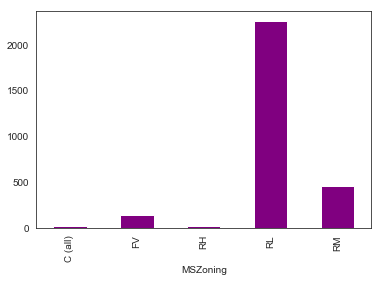

In [42]:
df.groupby('MSZoning').count()['Street'].plot(kind='bar', color='purple')

RL is by far the most commong so we will impute that

In [43]:
df['MSZoning'].fillna('RL', inplace=True)

 - Utilities, there are only 2 possibilities, we check which one is more common

In [44]:
df['Utilities'].unique()

array(['AllPub', 'NoSeWa', nan], dtype=object)

In [45]:
df.groupby('Utilities').count()['Street']  # We have only 1 case of No Sewage

Utilities
AllPub    2916
NoSeWa       1
Name: Street, dtype: int64

This means that this feature won't be able to help us because there are no "NoSeWa" in the test set. So we can safely drop the entire column. Statistically the entire feature has the same value

In [46]:
df.drop('Utilities', axis=1, inplace=True)

 - Exterior1st and Exterior2nd are the material covering the house

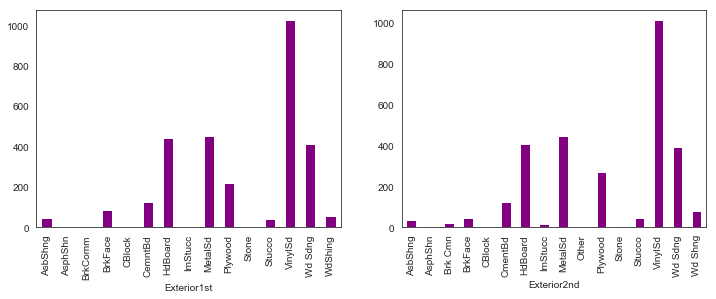

In [47]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
df.groupby('Exterior1st').count()['Street'].plot(kind='bar', ax=ax[0], color='purple')
df.groupby('Exterior2nd').count()['Street'].plot(kind='bar', ax=ax[1], color='purple')

There are only 1 NA on each Exterior and we can set it to the mode of each feature "VinylSd"

In [48]:
df['Exterior1st'].fillna("VinylSd", inplace=True)
df['Exterior2nd'].fillna("VinylSd", inplace=True)

**Progress Report**

In [49]:
df.isnull().sum()[df.isnull().sum() > 0]

Electrical     1
KitchenQual    1
Functional     2
SaleType       1
dtype: int64

 - For all these we have only 1 or 2 NaNs so we can just impute whichever is the most common

In [50]:
df.groupby('Electrical').count()['Street']

Electrical
FuseA     188
FuseF      50
FuseP       8
Mix         1
SBrkr    2671
Name: Street, dtype: int64

In [51]:
df['Electrical'].fillna('SBrkr', inplace=True)

In [52]:
df.groupby('KitchenQual').count()['Street']

KitchenQual
Ex     205
Fa      70
Gd    1151
TA    1492
Name: Street, dtype: int64

In [53]:
df['KitchenQual'].fillna("TA", inplace=True)

In [54]:
df.groupby("Functional").count()['Street']

Functional
Maj1      19
Maj2       9
Min1      65
Min2      70
Mod       35
Sev        2
Typ     2717
Name: Street, dtype: int64

In [55]:
df['Functional'].fillna("Typ", inplace=True)

In [56]:
df.groupby('SaleType').count()['Street']

SaleType
COD        87
CWD        12
Con         5
ConLD      26
ConLI       9
ConLw       8
New       239
Oth         7
WD       2525
Name: Street, dtype: int64

In [57]:
df['SaleType'].fillna("WD", inplace=True)

#### Checking Null Values

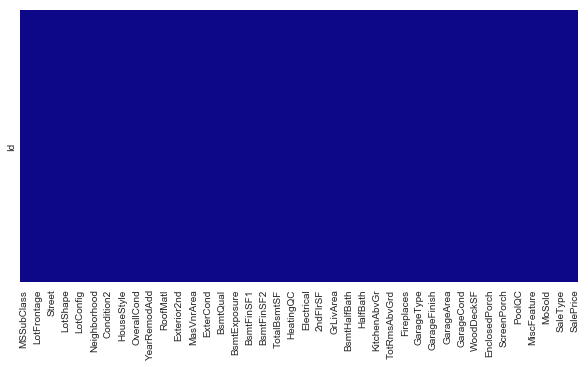

In [58]:
plt.subplots(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')

In [59]:
df.isnull().any().any()  # No more Null Values in our Dataset

False

**Our Data is now Free of Null Values, we can then chekc for Outliers**

### Categorical Values as Numeric

Some values are supposed to be categorical, but instead are encoded as numbers. This can be problematic

Other values like Year and Month might not hold a linear relationship with the target variable and there are no decimals. So we can treat those as categories as there arent that many 

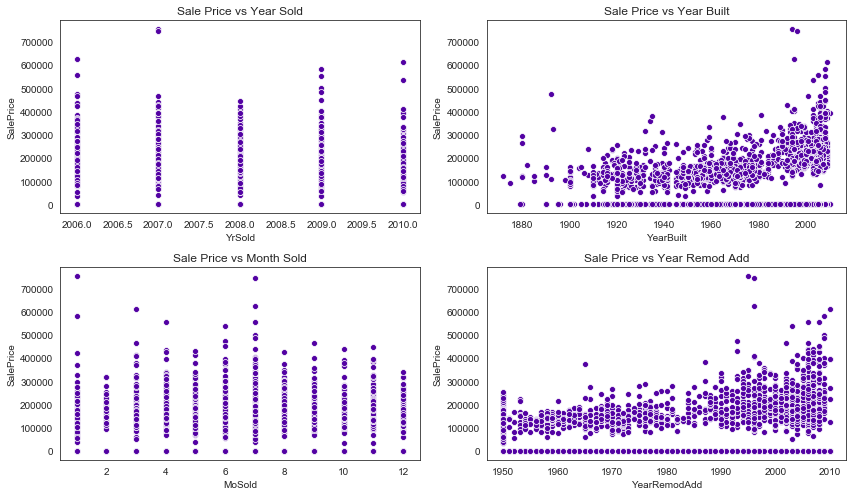

In [60]:
plt.subplots(figsize=(12,7))
plt.subplot(221)
plt.title('Sale Price vs Year Sold')
sns.scatterplot(data=df, x='YrSold', y='SalePrice')
plt.subplot(222)
plt.title('Sale Price vs Year Built')
sns.scatterplot(data=df, x='YearBuilt', y='SalePrice')
plt.subplot(223)
plt.title('Sale Price vs Month Sold')
sns.scatterplot(data=df, x='MoSold', y='SalePrice')
plt.subplot(224)
plt.title('Sale Price vs Year Remod Add')
sns.scatterplot(data=df, x='YearRemodAdd', y='SalePrice')
plt.tight_layout()

At a first glance through the Data Description these can be:
 - OverallQual
 - OverallCond
 - MSSubClass
 
 - Year and Month Values need to be checked. We see that Year and Month sold can be turned into a categorical, but Year of Build and Remodeled are too many to turn into categorical

In [61]:
df['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40, 150], dtype=int64)

In [62]:
df['MSSubClass'] = df['MSSubClass'].apply(str)

In [63]:
df['YrSold'] = df['YrSold'].apply(str)

In [64]:
df['MoSold'] = df['MoSold'].apply(str)

In [65]:
# This was created to see if we wanted a datetime function (didn't prove useful)
def sold_date(x):
    year = x[0]
    month = x[1]
    day = 1
    return pd.datetime(year, month, day)

**Note:** This date time functions we're tried but then discarded. Left for documentation 

In [66]:
#df['DateSold'] = df[['YrSold', 'MoSold']].apply(sold_date, axis=1)

We can then drop the year and month sold

In [67]:
#df.drop('YrSold', axis=1, inplace=True)
#df.drop('MoSold', axis=1, inplace=True)

#df['YrSold'] = df['YrSold'].apply(str)
#df['MoSold'] = df['MoSold'].apply(str)

**As Overall Quality and Condition have a certain order to their numbers, we must check if we want them as Categorical Values**

Text(0.5,1,'OverallCond Distribution')

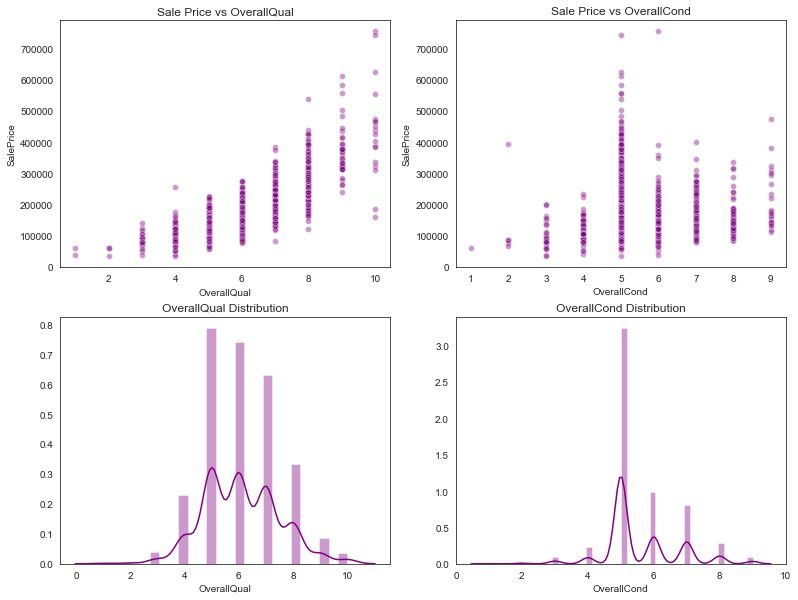

In [68]:
plt.subplots(figsize=(13,10))
plt.subplot(221)
sns.scatterplot(data=df[df['SalePrice'] != 0], x='OverallQual', y='SalePrice', alpha=0.4, color='purple')
plt.title("Sale Price vs OverallQual")
plt.subplot(222)
sns.scatterplot(data=df[df['SalePrice'] != 0], x='OverallCond', y='SalePrice', alpha=0.4, color='purple')
plt.title("Sale Price vs OverallCond")
plt.subplot(223)
sns.distplot(df[df['SalePrice'] != 0]['OverallQual'], color='purple')
plt.title("OverallQual Distribution")
plt.subplot(224)
sns.distplot(df[df['SalePrice'] != 0]['OverallCond'], color='purple')
plt.title("OverallCond Distribution")

There seems to be an obvious linear relationship between Sale Price and Overall Quality. The Overall Condition on the other hand seems to have a bit of a non linear relationship where a lot of the houses stay at Condition 5 but price ranges a lot.

We will make OverallCond a categorical and leave Quality as a Numerical

In [69]:
df['OverallCond'] = df['OverallCond'].apply(str)

We can also check if bucketizing these 2 variables might be better than leaving them as numeric or so many categories

### Outliers

We must also check for Outliers that might throw our model off

In [70]:
df.get_dtype_counts()

float64    11
int64      22
object     46
dtype: int64

In [71]:
numeric_columns = df.describe().columns
numeric_columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

These are all the columns that have numerical ranges, we will then evaluate each one to check for outliers

We will use the IQR method which will calculate the Range between the 0.25 quartile and 0.75 quartile and then check all values outside of a specified range

In [72]:
num_df = df[numeric_columns]

In [73]:
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)

In [74]:
IQR = Q3 - Q1  # Pandas Series with all IQRs per column

In [75]:
outliers_df = pd.DataFrame({'Q1':Q1, 'Q3':Q3, 'IQR':IQR})
outliers_df.head()

,Q1,Q3,IQR
LotFrontage,60.0,80.0,20.0
LotArea,7478.0,11570.0,4092.0
OverallQual,5.0,7.0,2.0
YearBuilt,1953.5,2001.0,47.5
YearRemodAdd,1965.0,2004.0,39.0


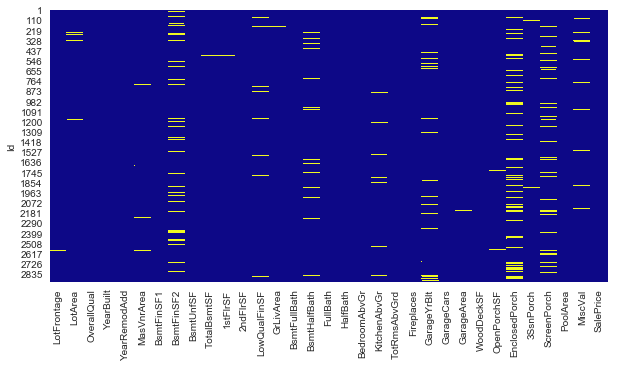

In [76]:
plt.subplots(figsize=(10,5))
sns.heatmap((num_df < (Q1 - 3 * IQR)) | (num_df > (Q3 + 3 * IQR)), cbar=False, cmap='plasma')

There seems to be a lot of Outliers considering we're doing 3 IQR. This could be because the data is not normally distributed and has a lot of 0s, (example of columns we imputed when we hunted NA values

In [77]:
len(num_df.columns)  # We can plot this  in a 5 x 7 matrix

33

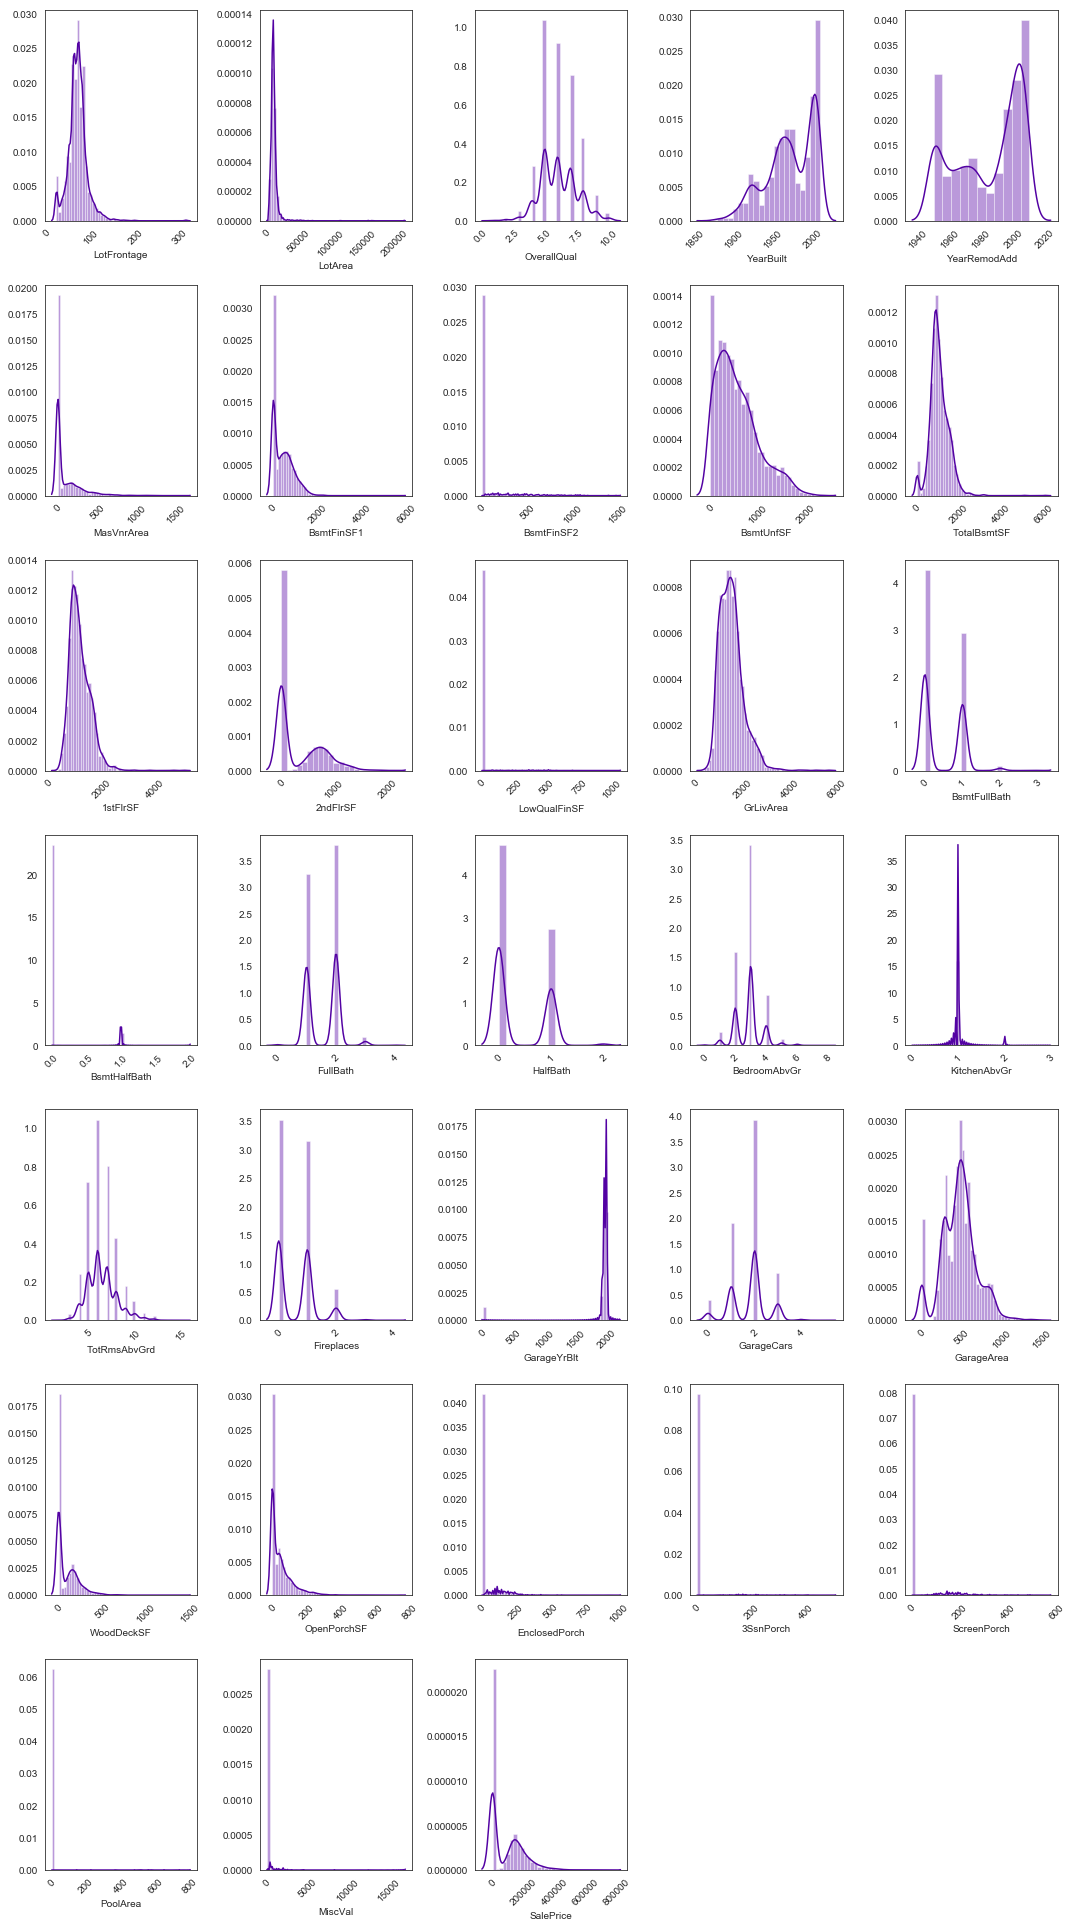

In [78]:
plt.subplots(figsize=(15, 30))
for i, col in enumerate(num_df.columns):
    plt.subplot(8,5,i+1)
    sns.distplot(num_df[col])
    plt.xticks(rotation=45)
plt.tight_layout()

The distributions where they are mostly 0s with a few non zero's or extremely skewed distributions can't use the IQR because it will be too easy to get a lot of data out of the set 

We will try to find the outliers using scatterplots (mostly against the SalesPrice)

In [79]:
check_columns = ['LotFrontage', 'LotArea', 'YearBuilt','MasVnrArea',
                 'BsmtFinSF1', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                 'GrLivArea', 'GarageArea', 'WoodDeckSF',
                 'OpenPorchSF', 'SalePrice']  # These are the columns we want to check for outliers

We create a dataframe with the IQR values to be able to use them later on

In [80]:
outliers_df_check = outliers_df.loc[check_columns]
outliers_df_check['L1.5IQR'] = outliers_df_check['Q1'] - outliers_df_check['IQR'] * 1.5
outliers_df_check['H1.5IQR'] = outliers_df_check['Q1'] + outliers_df_check['IQR'] * 1.5
outliers_df_check['L5IQR'] = outliers_df_check['Q1'] - outliers_df_check['IQR'] * 5
outliers_df_check['H5IQR'] = outliers_df_check['Q1'] + outliers_df_check['IQR'] * 5
outliers_df_check

,Q1,Q3,IQR,L1.5IQR,H1.5IQR,L5IQR,H5IQR
LotFrontage,60.0,80.0,20.0,30.00,90.00,-40.0,160.0
LotArea,7478.0,11570.0,4092.0,1340.00,13616.00,-12982.0,27938.0
YearBuilt,1953.5,2001.0,47.5,1882.25,2024.75,1716.0,2191.0
MasVnrArea,0.0,163.5,163.5,-245.25,245.25,-817.5,817.5
BsmtFinSF1,0.0,733.0,733.0,-1099.50,1099.50,-3665.0,3665.0
BsmtUnfSF,220.0,805.0,585.0,-657.50,1097.50,-2705.0,3145.0
TotalBsmtSF,793.0,1302.0,509.0,29.50,1556.50,-1752.0,3338.0
1stFlrSF,876.0,1387.5,511.5,108.75,1643.25,-1681.5,3433.5
2ndFlrSF,0.0,704.0,704.0,-1056.00,1056.00,-3520.0,3520.0
GrLivArea,1126.0,1743.5,617.5,199.75,2052.25,-1961.5,4213.5


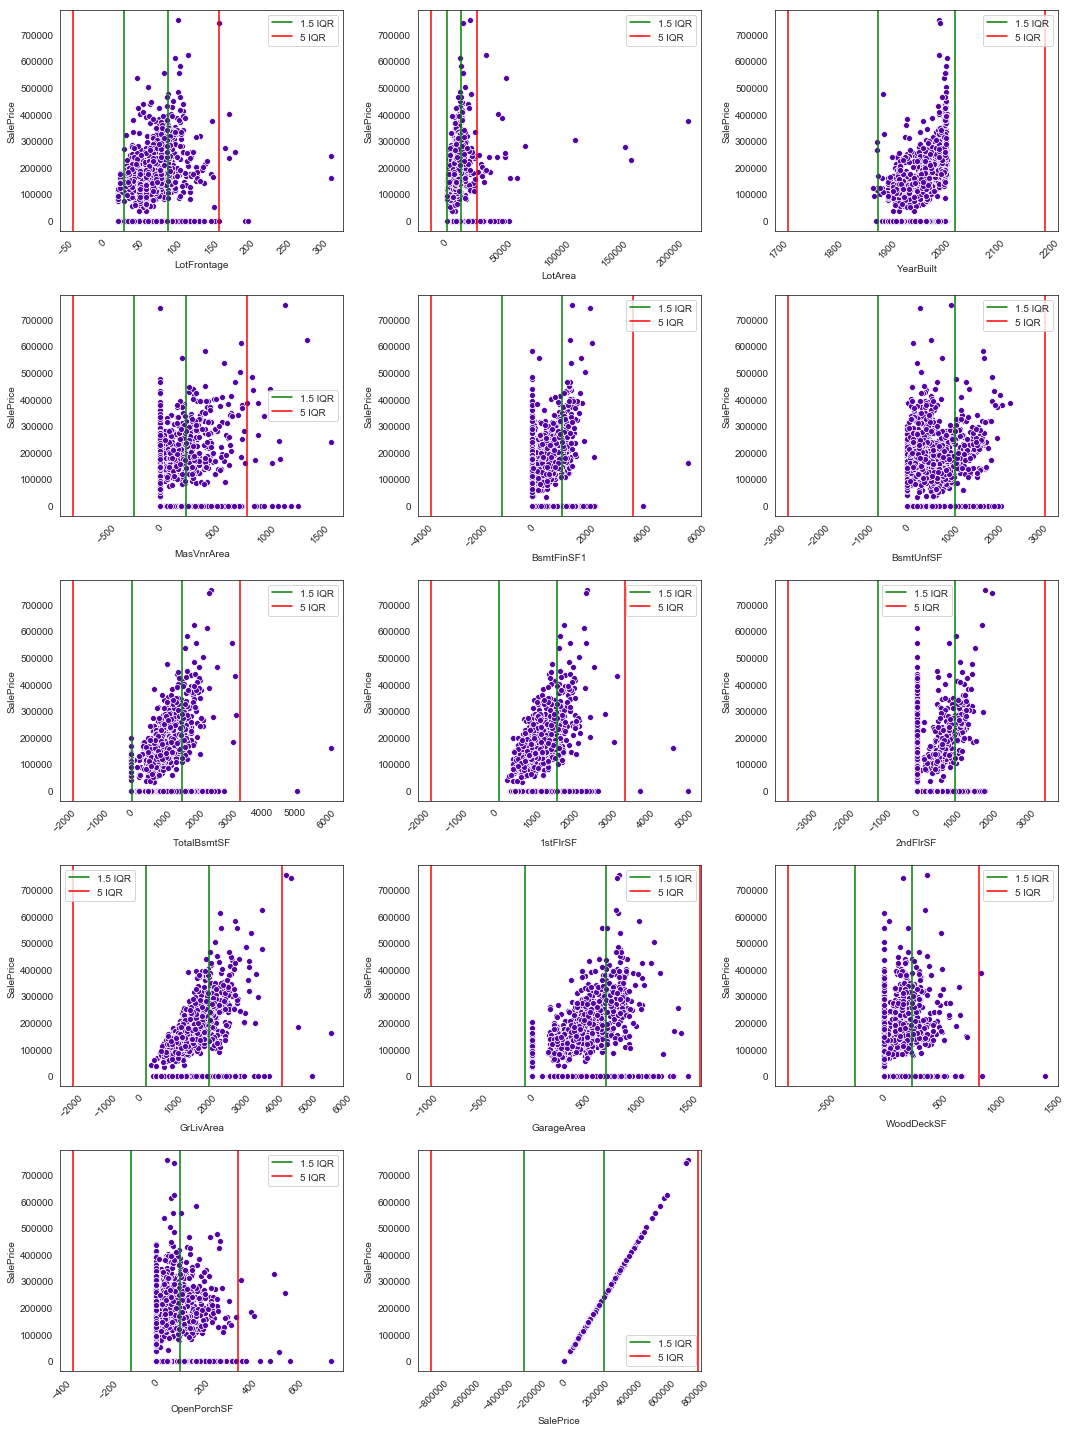

In [81]:
plt.subplots(figsize=(15,20))
for i, col in enumerate(check_columns):
    plt.subplot(5, 3, i + 1)
    sns.scatterplot(data=df, y='SalePrice', x=col)
    plt.axvline(outliers_df_check.loc[col, 'L1.5IQR'], color='green', label='1.5 IQR')
    plt.axvline(outliers_df_check.loc[col, 'H1.5IQR'], color='green')
    plt.axvline(outliers_df_check.loc[col, 'L5IQR'], color='red', label='5 IQR')
    plt.axvline(outliers_df_check.loc[col, 'H5IQR'], color='red')
    plt.xticks(rotation=45)
    plt.legend()
plt.tight_layout()

We can see how the bad distribution of data (a lot of 0s) creates problems using IQRs. Meaning that there are so many 0s that the Q1 becomes 0 and Q3 a very low number so a lot of values end up as outliers

However from the visualization we can see some obvious outliers.

 - 2 in LotFrontage > 300
 - 4 in LotArea > 100000
 - 1 in MasVnrArea > 1500
 - 2 in BsmtFinSF1 > 4000
 - 2 in TotalBsmtSF > 4000
 - 3 in 1stFlrSF > 3500
 - 3 in GrLivArea > 4000 but less than 300k in Sale Price
 - 3 in WoodDeckSF > 840

As we can't erase rows for either losing data or removing test data, we need to clip those outlier values to more meaningful numbers like the 5 IQR or the top values of the non-outliers

#### Fixing the worst outliers

In [82]:
df.loc[df['LotFrontage'] > 300, 'LotFrontage'] = 75
df.loc[df['LotArea'] > 100000, 'LotArea'] = 75000
df.loc[df['MasVnrArea'] > 1500, 'MasVnrArea'] = 1100
df.loc[df['BsmtFinSF1'] > 4000, 'BsmtFinSF1'] = outliers_df_check.loc['BsmtFinSF1', "H5IQR"]
df.loc[df['TotalBsmtSF'] > 4000, 'TotalBsmtSF'] = outliers_df_check.loc['TotalBsmtSF', "H5IQR"]
df.loc[df['1stFlrSF'] > 3500, '1stFlrSF'] = outliers_df_check.loc['1stFlrSF', 'H5IQR']
df.loc[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000), 'GrLivArea'] = outliers_df_check.loc['GrLivArea', 'H5IQR']
df.loc[df['WoodDeckSF'] > 840, 'WoodDeckSF'] = outliers_df_check.loc['WoodDeckSF', 'H5IQR']

**We have taken care of the worst outliers** 

### Redundant Variables and Multicolinearity

We need to check the correlation between the different features and the relation to the target variable to make sure that we don't have multicollinearity or non-related features

As we don't want the Price = 0 of the test set to influence the correlation between features and target we will separate the train and test set and work on the train test, then we can drop columns on the df dataset and continue

In [83]:
cor_train = df[df["SalePrice"] != 0]

In [84]:
corrmap = cor_train.corr()

In [85]:
print("Min Correlation: {}".format(corrmap.describe().loc['min'].min()))

Min Correlation: -0.508737751404077


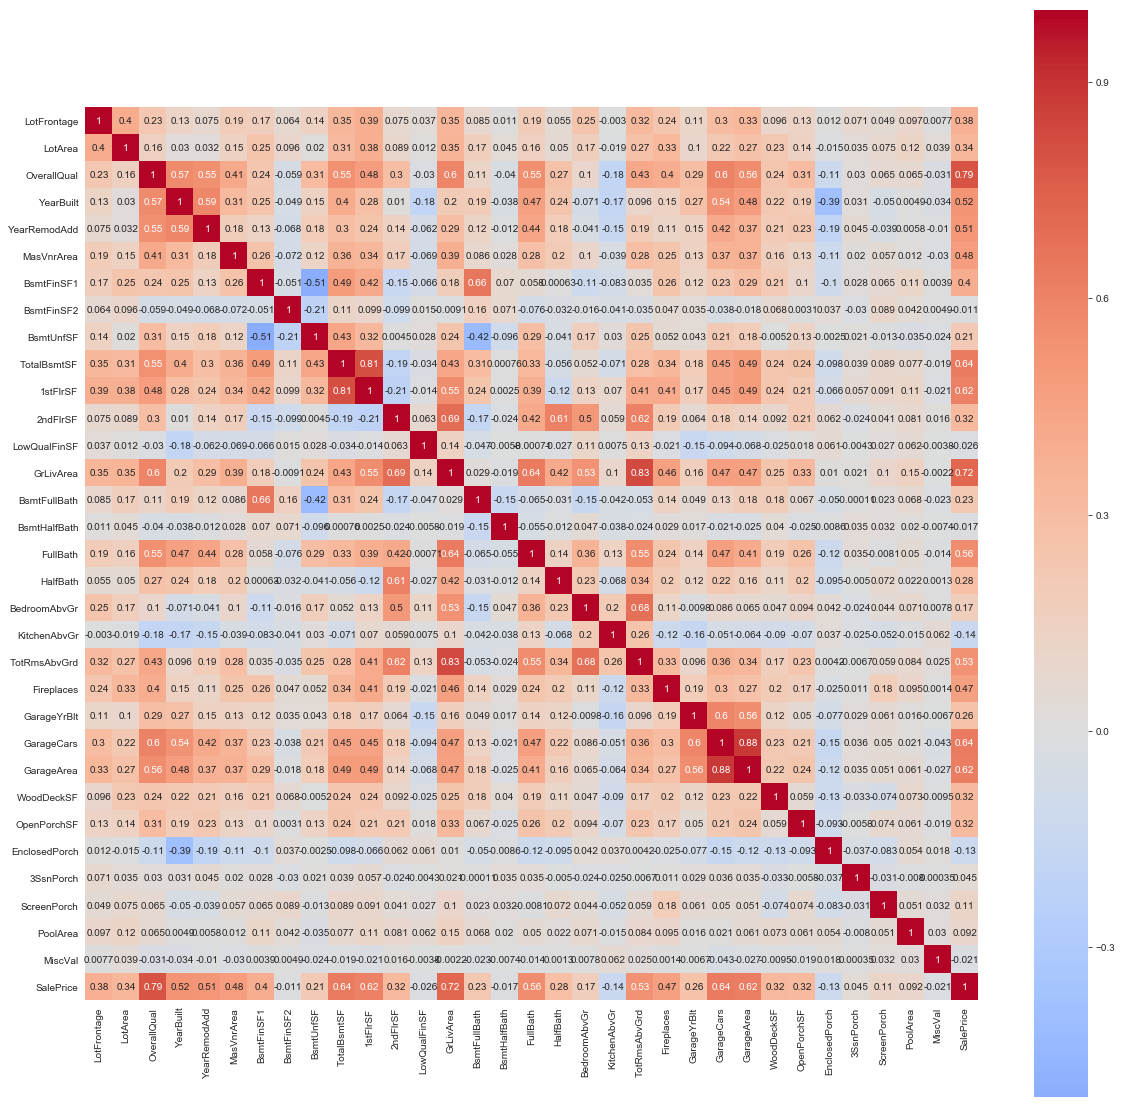

In [86]:
plt.subplots(figsize=(20,20))
sns.heatmap(corrmap, cmap='coolwarm', square=True, center=0, annot=True)

Seems like we have some related features that have more than 0.8 pearson correlation between each other. This can cause an issue of multicolinearity and we can safely remove one of the 2 variables as they are both telling us the same thing 

 - 1stFlrSF and TotalBsmtSF
 - TotRmsAbvGrd and GrLivArea
 - GarageArea and GarageCars

Makes sense these variables are correlated as they are not independent of each other.  
The Square Footage of the Total Basement and the 1st Floor Square Footage are related because a House normally has 1 basement and the size will be close to the 1st floor

Also, Total Rooms above ground and General Living Area are also very correlated as it stands to reason that having more rooms above ground means there is more area.

Lastly Garage Area and Garage Cars are correlated because more area means more cars in the garage

 So we drop: 
  - 1stFlrSF as it has a bit less correlation with the target variable
  - TotRmsAbvGrd because it has less correlation with SalePrice
  - GarageArea because it has less correlation with the SalePrice

In [87]:
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
df.drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'], axis=1, inplace=True)

### Feature distribution checking

Linear Models like their features and targets to be normally distributed, we already saw that the SalePrice was not, so we also check other features

In [88]:
cor_train = df[df["SalePrice"] != 0]
corrmap = cor_train.corr()

In [89]:
corrmap['SalePrice'].sort_values(ascending=False)[1:11]

TotalSF         0.807185
OverallQual     0.790982
GrLivArea       0.720313
GarageCars      0.640409
TotalBsmtSF     0.638263
FullBath        0.560664
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477517
Fireplaces      0.466929
Name: SalePrice, dtype: float64

In [90]:
distribution_check = corrmap['SalePrice'].sort_values(ascending=False)[1:11].index

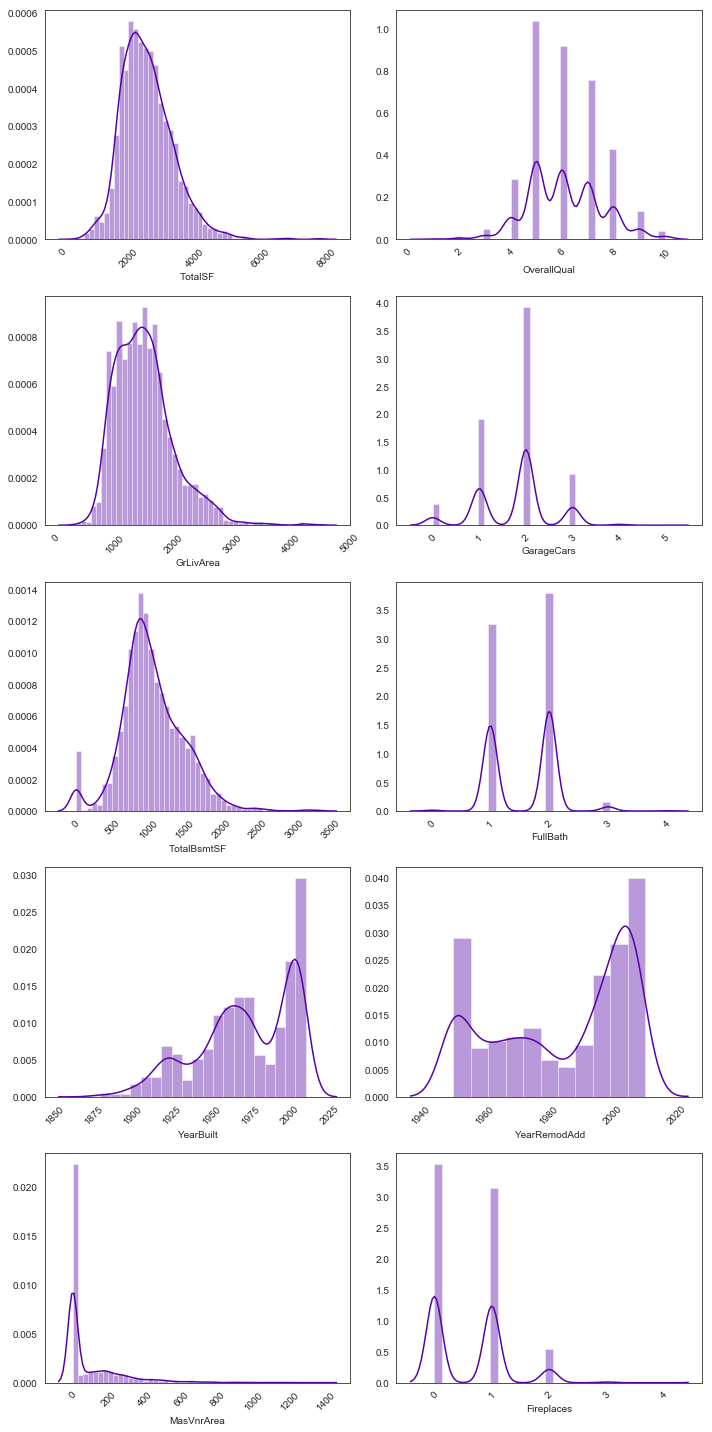

In [91]:
plt.subplots(figsize=(10, 20))
for i, col in enumerate(distribution_check):
    plt.subplot(5,2,i+1)
    sns.distplot(df[col])
    plt.xticks(rotation=45)
plt.tight_layout()

We can see 3 numerical features that don't seem to be normally distributed GrLivArea, TotalSF and TotalBsmtSF

In [92]:
print("Shapiro p-value of 'GrLivArea': {}".format(shapiro(df['GrLivArea'])[1]))
print("Shapiro p-value of 'TotalSF': {}".format(shapiro(df['TotalSF'])[1]))
print("Shapiro p-value of 'TotalBsmtSF': {}".format(shapiro(df['TotalBsmtSF'])[1]))

Shapiro p-value of 'GrLivArea': 7.432296368702551e-32
Shapiro p-value of 'TotalSF': 2.2586391571049918e-27
Shapiro p-value of 'TotalBsmtSF': 7.473503541349901e-25


They are not normally distributed. So we can use a transformation to make it normally distributed

**Note:** We originally applied the following code, but it increased our error on Kaggle, so we leave it here for documentation but commented so it doesn't run

In [93]:
#df['GrLivArea'] = df['GrLivArea'].apply(np.log1p)
#df['TotalSF'] = df['TotalSF'].apply(np.log1p)
#f['TotalBsmtSF'] = df['TotalBsmtSF'].apply(np.log1p)

This should work in theory, but it didn't. We can speculate that when we transformed the variable, it reduces the number and resolution by using smaller numbers. Maybe the loss of information due to the transformation was more than what we gained from fixing the skewness.

### Non linear relationship between features and target variable

As we're using linear models to predict the sale price. The model will behave better if the features are linearly correlated to the target variable. If they are not, we can transform them as well to make the model behave better

In [94]:
relation_check = corrmap['SalePrice'].sort_values(ascending=False).index

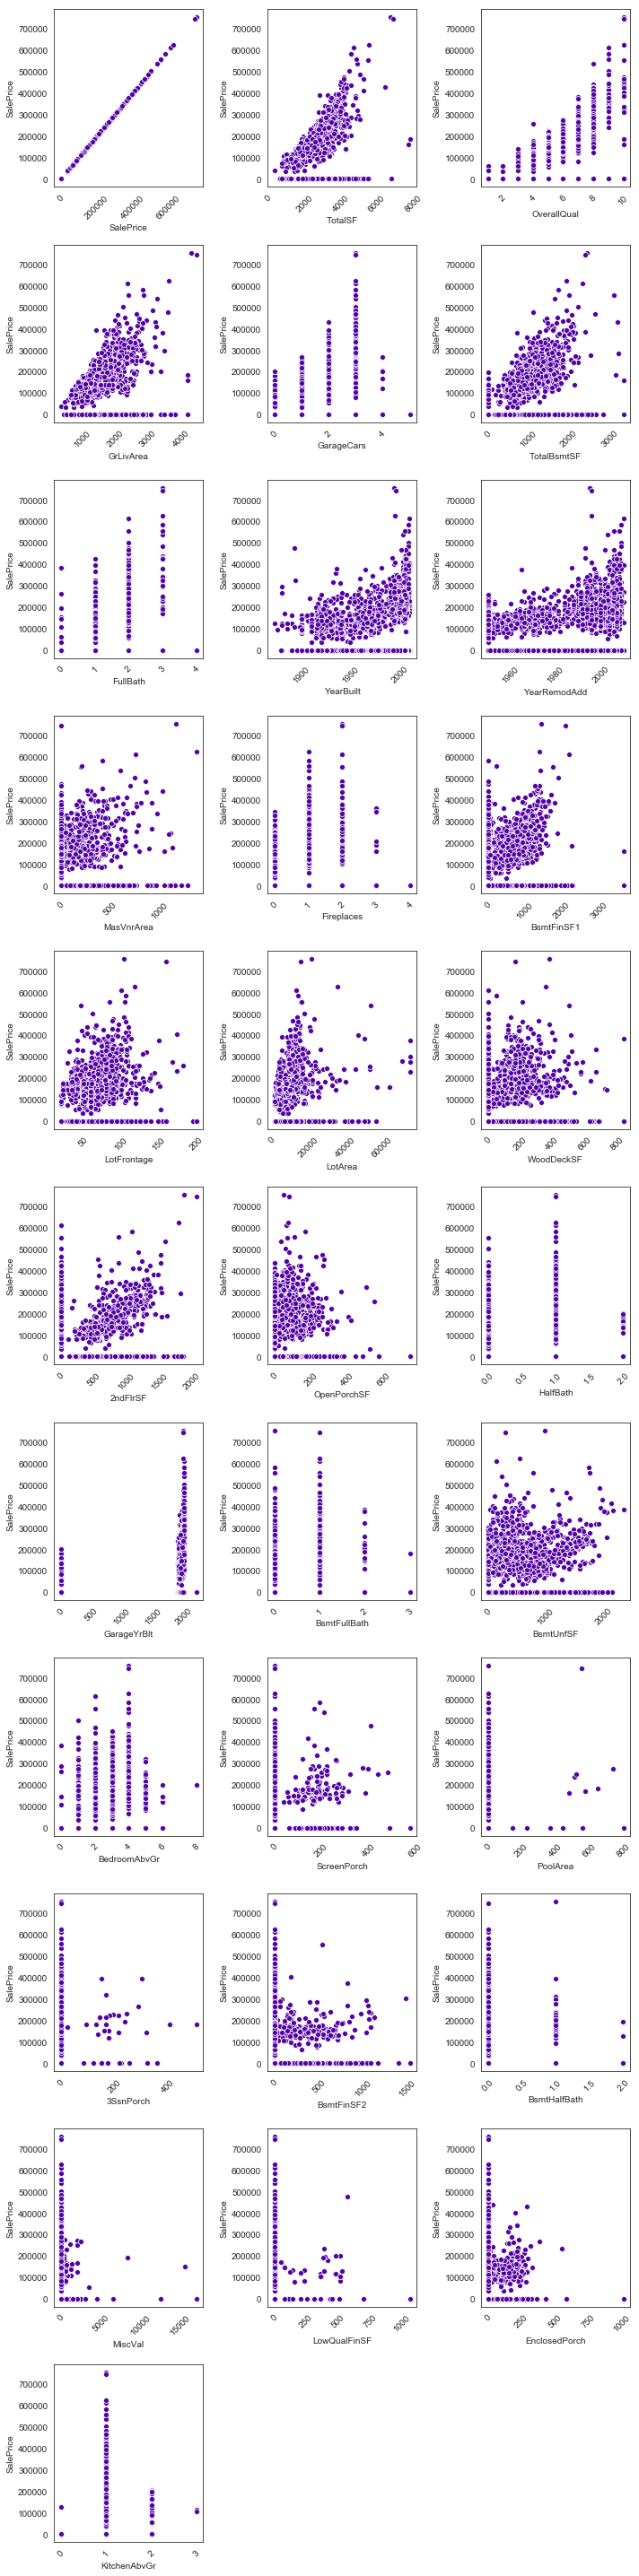

In [95]:
plt.subplots(figsize=(10, 40))
for i, col in enumerate(relation_check):
    plt.subplot(11,3,i+1)
    sns.scatterplot(data=df, y='SalePrice', x=col)
    plt.xticks(rotation=45)
plt.tight_layout()

**Note:** Creating the square of these features had a good result, but not better than what we already have.  
Removing the original features after the squares decreased our score significantly. I will comment these lines as to not run into that problem but leave it for documentation purposes

In [96]:
#df['OverallQual_sq'] = df['OverallQual'].apply(lambda x: x ** 2)
#df.drop('OverallQual', axis=1, inplace=True)

In [97]:
#df['TotalSF_sq'] = df['TotalSF'].apply(lambda x: x ** 2)
#df.drop('TotalSF', axis=1, inplace=True)

In [98]:
#df['GrLivArea_sq'] = df['GrLivArea'].apply(lambda x: x ** 2)
#df.drop('GrLivArea', axis=1, inplace=True)

## Feature Creation 

The last part of our data wrangling will be feature creation. There are 3 basic features that we can create for our data.  
 - Interaction between variables
 - A positive Power transformation (x^2)
 - A negative Power Transformation (x^-1)

**Note:** This entire section was created but decreased the score slightly so it's not used for the final model. It is left here for documentation processes

First we need to grab the numerical categories only and then transform them into new variables

In [99]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler

In [100]:
cols = df.columns
num_cols = []
cat_cols = []
price = df['SalePrice']
df_index = df.index
for col in cols:
    if df[col].dtype != 'O':
        num_cols.append(col)
    else:
        cat_cols.append(col)

In [101]:
num_df = df[num_cols]
cat_df = df[cat_cols]

Now we create the new features. We will do the Square and 3rd power of each numerical feature.  
As we're using Lasso Regression, this will have some feature selection. 

In [102]:
# This was an attempt to limit the features created. Didn't reduce the error at the end
# We drop the Sale Price because we 're not going to transform this as it's the target variable
#num_df.drop('SalePrice', axis=1, inplace=True)
#for col in num_df.columns:
    #num_df[col + "^2"] = num_df[col].apply(lambda x: x ** 2)  # Square Power
    #num_df[col + "^3"] = num_df[col].apply(lambda x: x ** 3)  # Cube Power
    #num_df[col + "_sqrt"] = num_df[col].apply(lambda x: np.sqrt(x))  # Square Root
    #num_df[col + "^curt"] = num_df[col].apply(lambda x: np.cbrt(x))  # Cube Root
    #num_df[col + "_log"] = num_df[col].apply(lambda x: np.log1p(x))  # Log1p

In [103]:
# Scaling our variables actually had a worse impact in our score, we can spaculate that:
# The loss of information from loss in resolution from scaling is worse than the gain from scaling
#mm_scaler = MinMaxScaler()
#std_scaler = StandardScaler()
#num_df_scaled = scaler.fit_transform(num_df)
#num_df = pd.DataFrame(num_df_scaled, columns=num_df.columns, index=df_index)

In [104]:
# This is to reform the new features into a single dataframe
#df = pd.concat([num_df, cat_df, price], axis=1)

In [105]:
# Check the size of our new features
print(len(df.columns))

77


## ML Section

### Dataset Preparation and Split 

In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_log_error

We will create the dummy variables, then separate train/test set and then create our Internal Test set from the Dummy Set

In [107]:
df_index = df.index

In [108]:
df_dummy = pd.get_dummies(df)
df_dummy['SalePrice'] = df_dummy['SalePrice'].apply(np.log1p)

In [109]:
train = df_dummy[df_dummy['SalePrice'] != 0]
test = df_dummy[df_dummy['SalePrice'] == 0]
test.drop('SalePrice', axis=1, inplace=True)

In [110]:
print("Lenght of Train set: {}".format(len(train)))
print("Lenght of Test set: {}".format(len(test)))

Lenght of Train set: 1460
Lenght of Test set: 1459


In [111]:
print("Test Set IDs: ")
print("Lowest ID: {}".format(test.index.min()))
print("Highest ID: {}".format(test.index.max()))
print("Rows in Test Set: {}".format(len(test)))

Test Set IDs: 
Lowest ID: 1461
Highest ID: 2919
Rows in Test Set: 1459


In [112]:
X = train.drop("SalePrice", axis=1)
y = train['SalePrice']

First we grab 10% of our data as our final test set as our regular test set has no labels to check

This is not used for training purposes. only to calculate the weights for the stacked model at the end of this section

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

As we have a true test set in the kaggle set, we don't need to check for generalization of our model in this notebook (Kaggle will do that for us when we submit our results), We will split a test set only to check the weights of a stacked model but we will train using the entire data.  
This will leak information to the calculation of the stacked model, but we're not trying to check the generalization of the model, we instead will check which one of the "overfitted" models are better. 

### Model 1 - Lasso Regression

The parameters in the param_grid are the final ones, there was an iterative process of finding these optimum points

In [114]:
param_grid = {'alpha':np.arange(0.0001, 0.003, 0.0001)}
model_lasso = GridSearchCV(Lasso(), param_grid=param_grid, scoring='r2', cv=3, verbose=1, n_jobs=-1)

In [115]:
model_lasso.fit(X, y)

Fitting 3 folds for each of 29 candidates, totalling 87 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   10.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [116]:
cv_results_lasso = pd.DataFrame(model_lasso.cv_results_)

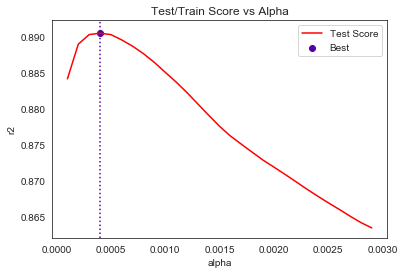

In [117]:
plt.title("Test/Train Score vs Alpha")
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_test_score'], color='red', label='Test Score')
#plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], color='blue', label='Train Score')
plt.axvline(model_lasso.best_params_['alpha'], linestyle=':')
plt.scatter(model_lasso.best_params_['alpha'], model_lasso.best_score_, marker='o', label='Best')
plt.xlabel('alpha')
plt.ylabel('r2')
plt.legend()

In [118]:
model_lasso.best_params_

{'alpha': 0.0004}

In [119]:
model_lasso.best_score_

0.8904288882888731

In [120]:
# Not true generalization as there is no unseen data, as the model used the entire data to train.
# We use this as a simple reference for the RMSLE
preds = model_lasso.predict(X_test)
print(mean_squared_log_error(y_test, preds) ** 0.5)
print(model_lasso.score(X_test, y_test))

0.007789363840305081
0.9288661771824335


In [121]:
print("Total Features: {}".format(len(X_train.columns)))
print("User Features: {}".format((model_lasso.best_estimator_.coef_ > 0).sum()))

Total Features: 336
User Features: 74


In [122]:
kaggle_preds = model_lasso.predict(test)
kaggle_df = pd.DataFrame({'Id': test.index, "SalePrice": kaggle_preds})
kaggle_df['SalePrice'] = kaggle_df['SalePrice'].apply(np.expm1)
kaggle_df.head()

,Id,SalePrice
0,1461,117489.443552
1,1462,153855.306197
2,1463,178852.314878
3,1464,202986.279937
4,1465,194874.041143


In [123]:
# This was produced only for debugging purposes. Final Model was the stacked one
#kaggle_df.to_csv("kaggle_housing_lasso_preds.csv",index=False)

### Model 2 - Ridge Regression

The parameters in the param_grid are the final ones, there was an iterative process of finding these optimum points

In [124]:
param_grid = {'alpha': np.arange(1, 20, 1)}
model_ridge = GridSearchCV(Ridge(), param_grid=param_grid, scoring='r2', cv=5, verbose=1)

In [125]:
model_ridge.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [126]:
cv_results_ridge = pd.DataFrame(model_ridge.cv_results_)

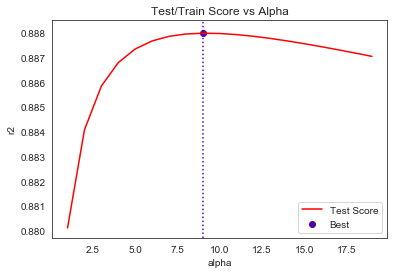

In [127]:
plt.title("Test/Train Score vs Alpha")
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_test_score'], color='red', label='Test Score')
#plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], color='blue', label='Train Score')
plt.axvline(model_ridge.best_params_['alpha'], linestyle=':')
plt.scatter(model_ridge.best_params_['alpha'], model_ridge.best_score_, marker='o', label='Best')
plt.xlabel('alpha')
plt.ylabel('r2')
plt.legend()

In [128]:
print(model_ridge.best_params_)
print(model_ridge.best_score_)

{'alpha': 9}
0.8879876766471374


In [129]:
# Not true generalization as there is no unseen data, as the model used the entire data to train.
# We use this as a simple reference for the RMSLE
preds = model_ridge.predict(X_test)
print(mean_squared_log_error(y_test, preds) ** 0.5)
print(model_ridge.score(X_test, y_test))

0.007586788676435105
0.9325035393639836


In [130]:
kaggle_preds = model_ridge.predict(test)
kaggle_df = pd.DataFrame({'Id': test.index, "SalePrice": kaggle_preds})
kaggle_df['SalePrice'] = kaggle_df['SalePrice'].apply(np.expm1)
kaggle_df.head()

,Id,SalePrice
0,1461,117166.422352
1,1462,160121.874004
2,1463,180729.850676
3,1464,200893.412990
4,1465,192521.001357


In [131]:
# This was produced only for debugging purposes. Final Model was the stacked one
#kaggle_df.to_csv("kaggle_housing_ridge_preds.csv",index=False)

### Model 3 - ElasticNet

The parameters in the param_grid are the final ones, there was an iterative process of finding these optimum points

In [132]:
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}

model_enet = GridSearchCV(ElasticNet(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1, cv=3)
model_enet.fit(X, y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [133]:
cv_results_enet = pd.DataFrame(model_enet.cv_results_)

In [134]:
cv_enet_pivot = pd.pivot_table(cv_results_enet, 'mean_test_score', 'param_alpha', 'param_l1_ratio')

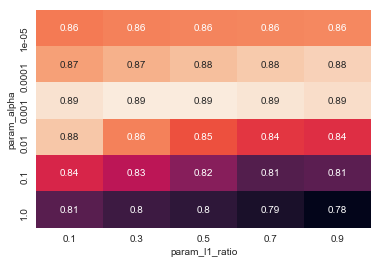

In [135]:
sns.heatmap(cv_enet_pivot, cbar=False, annot=True)

In [136]:
print(model_enet.best_params_)
print(model_enet.best_score_)

{'alpha': 0.001, 'l1_ratio': 0.3}
0.890062419161412


In [137]:
# Not true generalization as there is no unseen data, as the model used the entire data to train.
# We use this as a simple reference for the RMSLE
preds = model_enet.predict(X_test)
print(mean_squared_log_error(y_test, preds) ** 0.5)
print(model_enet.score(X_test, y_test))

0.007739571788879708
0.9297729145995464


In [138]:
kaggle_preds = model_enet.predict(test)
kaggle_df = pd.DataFrame({'Id': test.index, "SalePrice": kaggle_preds})
kaggle_df['SalePrice'] = kaggle_df['SalePrice'].apply(np.expm1)
kaggle_df.head()

,Id,SalePrice
0,1461,116677.011705
1,1462,154833.256750
2,1463,178825.122071
3,1464,202323.784283
4,1465,195373.398740


In [139]:
# This was produced only for debugging purposes. Final Model was the stacked one
#kaggle_df.to_csv("kaggle_housing_enet_preds.csv",index=False)

### Model Stacking - Calculating Weights

For this section we use a subset of the data to calculate the error while iterating through every possible weight combination between all 3 models to calculate the optimal weights

In [140]:
preds_lasso = model_lasso.predict(X_test)
preds_ridge = model_ridge.predict(X_test)
preds_enet = model_enet.predict(X_test)

In [141]:
r_list = []
l_list = []
e_list = []
RMSLE = []
for l in np.arange(0.1, 1, 0.01):
    for e in np.arange(0.1, 1-l, 0.01):
        r = 1 - l - e
        w_pred = preds_lasso * l + preds_ridge * r + preds_enet * e
        r_list.append(r)
        l_list.append(l)
        e_list.append(e)
        RMSLE.append(mean_squared_log_error(y_test, w_pred)**0.5)

results = pd.DataFrame({
    "Lasso": l_list,
    "Ridge": r_list,
    "ElasticNet": e_list,
    "RMSLE": RMSLE,
})

In [142]:
best_params = results[results['RMSLE'] == results['RMSLE'].min()]
best_params

,Lasso,Ridge,ElasticNet,RMSLE
0,0.1,0.8,0.1,0.007597


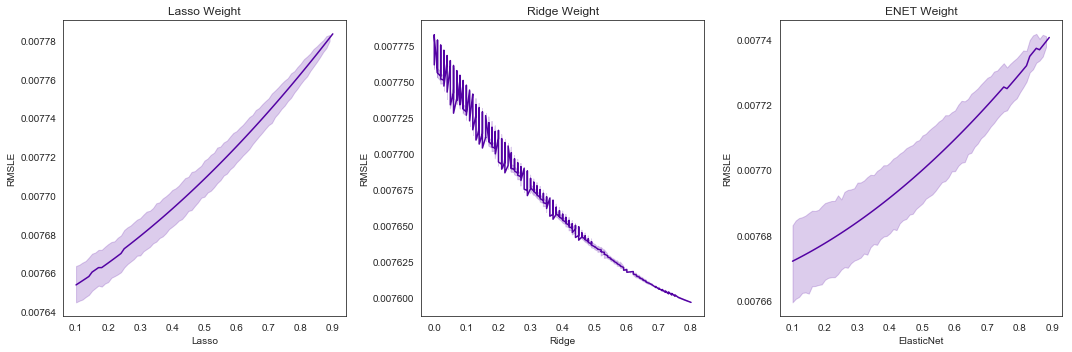

In [143]:
plt.subplots(figsize=(15,5))
plt.subplot(131)
sns.lineplot(data=results, x = 'Lasso', y='RMSLE')
plt.title("Lasso Weight")
plt.subplot(132)
sns.lineplot(data=results, x = 'Ridge', y='RMSLE')
plt.title("Ridge Weight")
plt.subplot(133)
sns.lineplot(data=results, x = 'ElasticNet', y='RMSLE')
plt.title("ENET Weight")
plt.tight_layout()

### Weighted Predictions

In [144]:
pred_lasso = model_lasso.predict(test)
pred_ridge = model_ridge.predict(test)
pred_enet = model_enet.predict(test)

In [145]:
stack_df = pd.DataFrame({
    'Lasso': pred_lasso,
    'Ridge': pred_ridge,
    'Enet': pred_enet,
})

In [146]:
stack_df['mean'] = stack_df['Lasso'] * best_params['Lasso'].values[0]\
    + stack_df['Ridge'] * best_params['Ridge'].values[0]\
    + stack_df['Enet'] * best_params['ElasticNet'].values[0]

In [147]:
kaggle_df = pd.DataFrame({
    'Id': test.index,
    'SalePrice': stack_df['mean'],
})

In [148]:
kaggle_df['SalePrice'] = kaggle_df['SalePrice'].apply(np.expm1)
kaggle_df.head()

,Id,SalePrice
0,1461,117149.637664
1,1462,158949.148052
2,1463,180350.031044
3,1464,201244.453716
4,1465,193038.721178


In [149]:
kaggle_df.to_csv("kaggle_housing_final_stacked_preds.csv",index=False)

**Note:** Even though we predicted for every model independently, this is the set that was submitted to Kaggle. The other ones were produced for debugging purposses